## Istotność zmiennych dla klasyfikacji

In [2]:
# Import Required Libraries
import pandas as pd
from joblib import Parallel, delayed, load
import shap
import matplotlib.pyplot as plt

# Ensure the SHAP plots are displayed in the notebook
shap.initjs()

c:\Users\janbi\anaconda3\envs\mgr_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load Trained Classifiers
with open('../models/trained_classifiers.pkl', 'rb') as file:
    classifiers = load(file)

In [4]:
with open("../data/processed/modelling_data.pkl", "rb") as file:
    data = load(file)

X = data["X_test"]
y = data["y_test"]

In [5]:
# Summarize the background data
background = shap.sample(X, 100)
X_sample = shap.sample(X, 100)

In [6]:
# Initialize a dictionary to store SHAP explainers for each classifier
shap_explainers = {}

# Loop through each classifier and initialize the SHAP explainer
for clf_name, clf in classifiers.items():
    # Use TreeExplainer for tree-based models, otherwise use KernelExplainer
    if hasattr(clf, 'tree_'):
        explainer = shap.TreeExplainer(clf)
    else:
        explainer = shap.KernelExplainer(clf.predict, background)
    
    shap_explainers[clf_name] = explainer

# Compute SHAP values for the sampled data
#shap_values_dict = {clf_name: explainer.shap_values(X_sample) for clf_name, explainer in shap_explainers.items()}

# Display the computed SHAP values
#shap_values_dict

In [7]:
# Function to compute SHAP values and print the output
def compute_shap_values(clf_name, explainer, X_sample):
    shap_values = explainer.shap_values(X_sample)
    print(f"SHAP values for {clf_name}: {shap_values}")
    return clf_name, shap_values

# Parallel computation of SHAP values
shap_values_list = Parallel(n_jobs=-1)(
    delayed(compute_shap_values)(clf_name, explainer, X_sample) for clf_name, explainer in shap_explainers.items()
)

In [8]:
# Convert the list of tuples back to a dictionary
shap_values_dict = dict(shap_values_list)

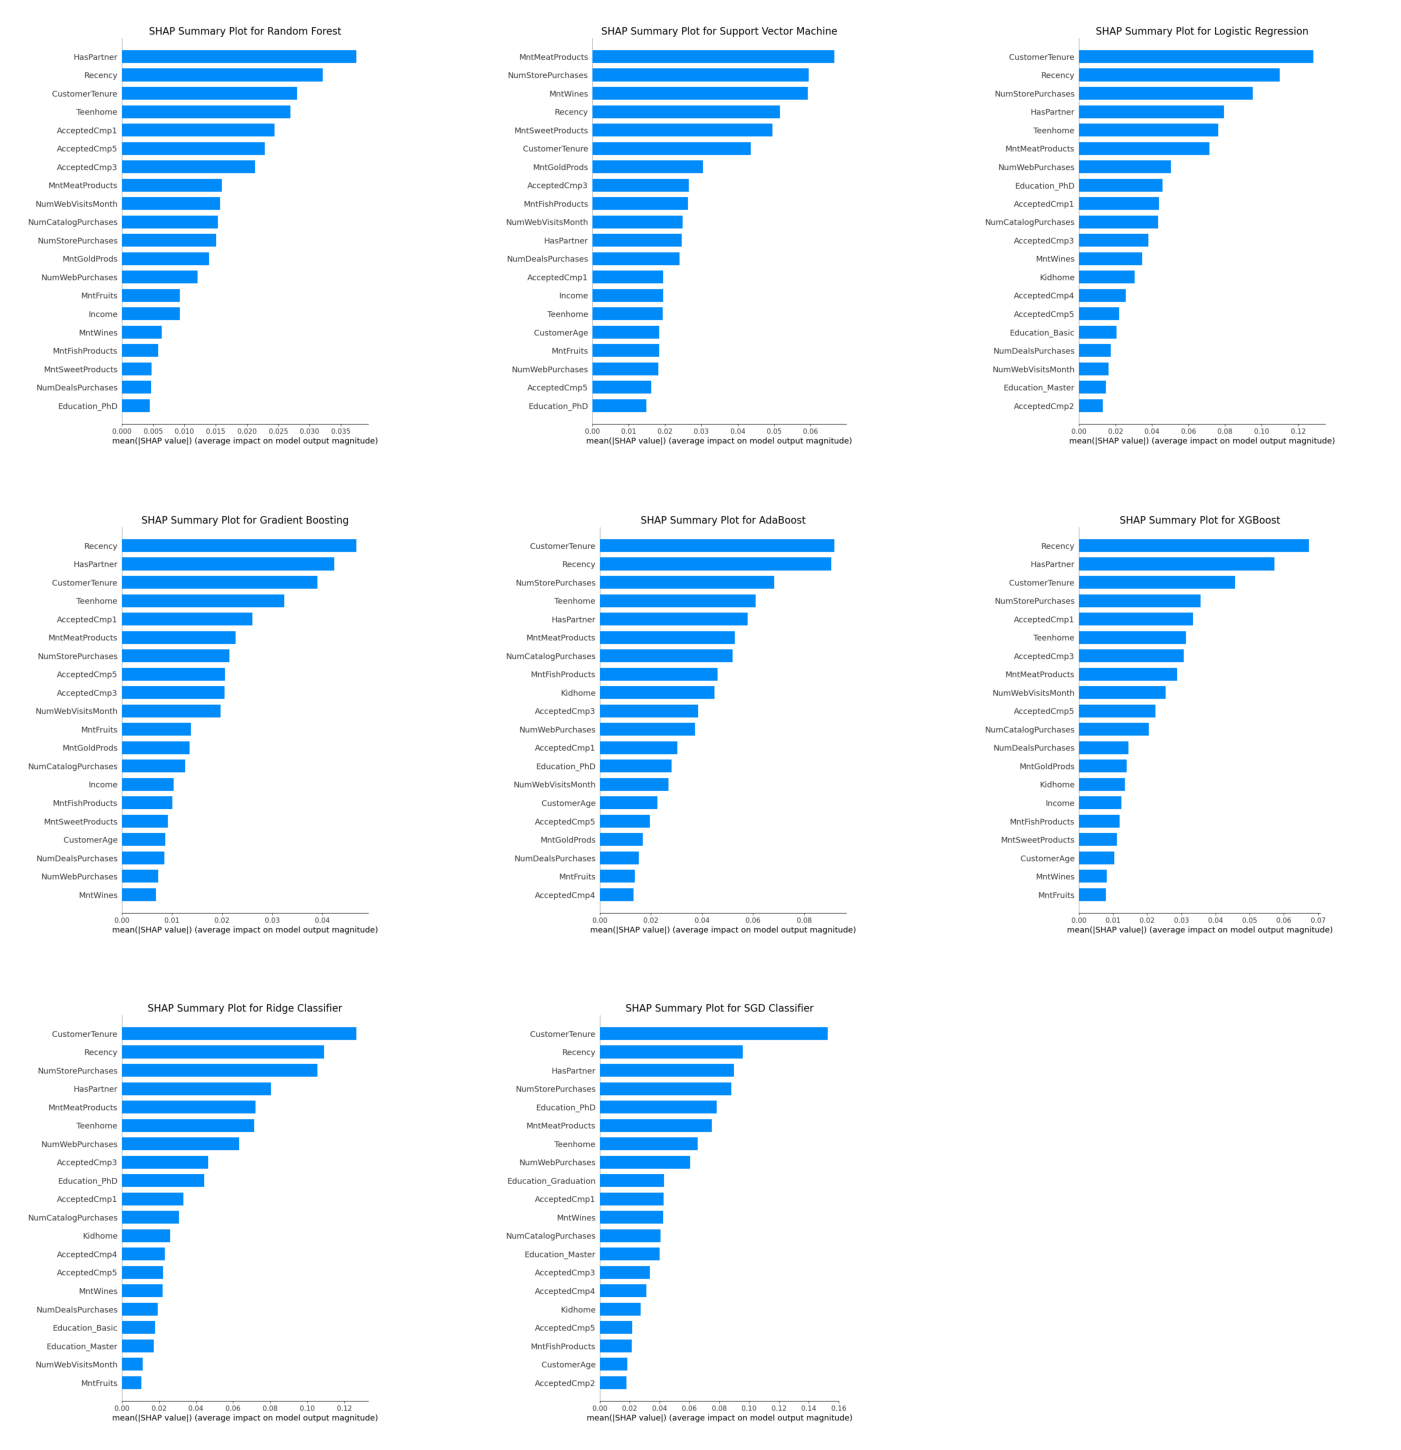

In [9]:
output_dir = "../reports/figures/shap_plots"
feature_names = data["feature_names"]

# Generate and save SHAP summary plots
for clf_name, shap_values in shap_values_dict.items():
    shap.summary_plot(shap_values, X_sample, feature_names=feature_names, show=False, plot_type="bar")
    plt.title(f"SHAP Summary Plot for {clf_name}", fontsize=16)
    plt.savefig(f"{output_dir}/{clf_name}_shap_summary.png", bbox_inches='tight', pad_inches=0.4)
    plt.close()

# Plot SHAP values for each classifier
num_classifiers = len(shap_values_dict)
num_cols = 3
num_rows = (num_classifiers + num_cols - 1) // num_cols

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5 * num_rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, (clf_name, _) in zip(axes, shap_values_dict.items()):
    img = plt.imread(f"{output_dir}/{clf_name}_shap_summary.png")
    ax.imshow(img)
    ax.axis('off')

# Hide any unused subplots
for i in range(num_classifiers, len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=2.5)
plt.show()


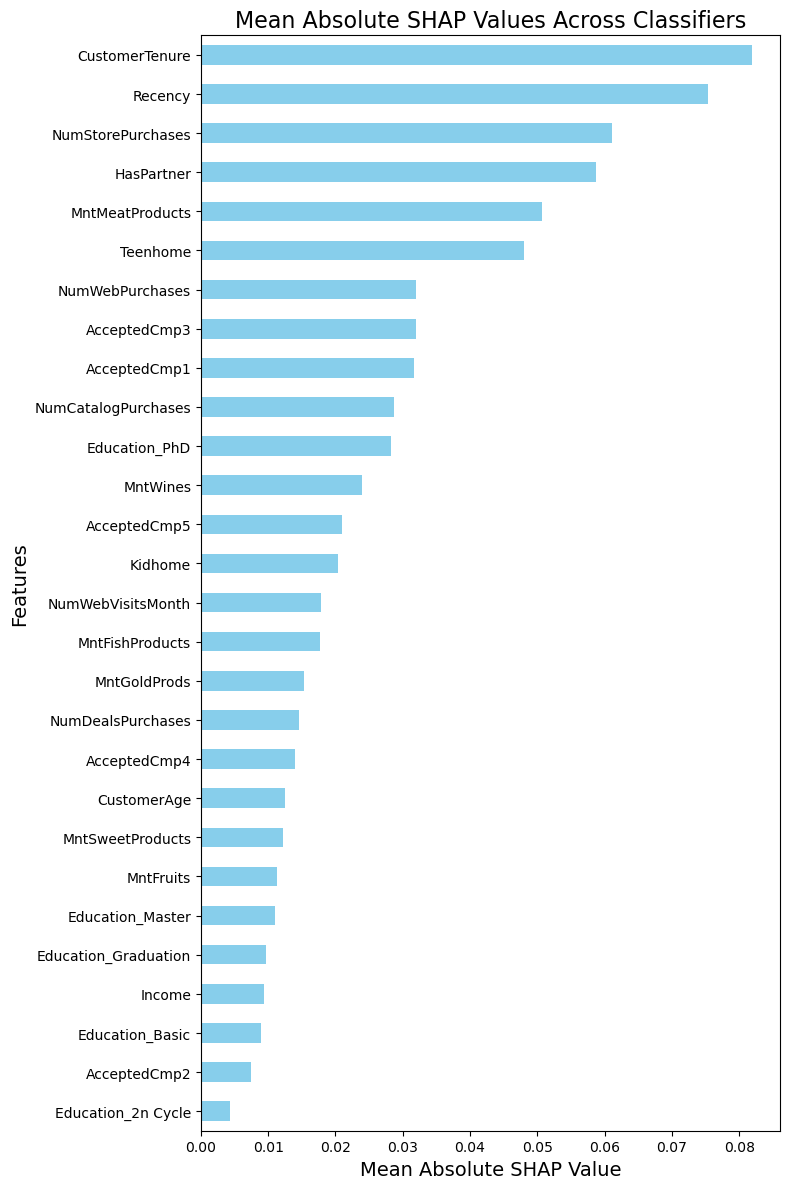

In [20]:
import numpy as np
# Combine SHAP values into a single DataFrame
shap_values_combined = pd.DataFrame()

for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(np.abs(shap_values), axis=0)  # Use absolute values for multi-class
    
    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(np.abs(shap_values), columns=feature_names)  # Take absolute values
    shap_values_combined = pd.concat([shap_values_combined, shap_df], axis=0)

# Calculate the mean absolute SHAP value for each feature
mean_absolute_shap_values = shap_values_combined.mean(axis=0)

# Sort features by mean absolute SHAP value
mean_absolute_shap_values = mean_absolute_shap_values.sort_values(ascending=False)

if 'Complain' in mean_absolute_shap_values.index:
    mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')

# Plot the mean absolute SHAP values as a bar plot
# Plot the mean absolute SHAP values as a horizontal bar plot
plt.figure(figsize=(8, 12))  # Adjust the figure size for better readability
mean_absolute_shap_values.plot(kind='barh', color='skyblue')
plt.title('Mean Absolute SHAP Values Across Classifiers', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

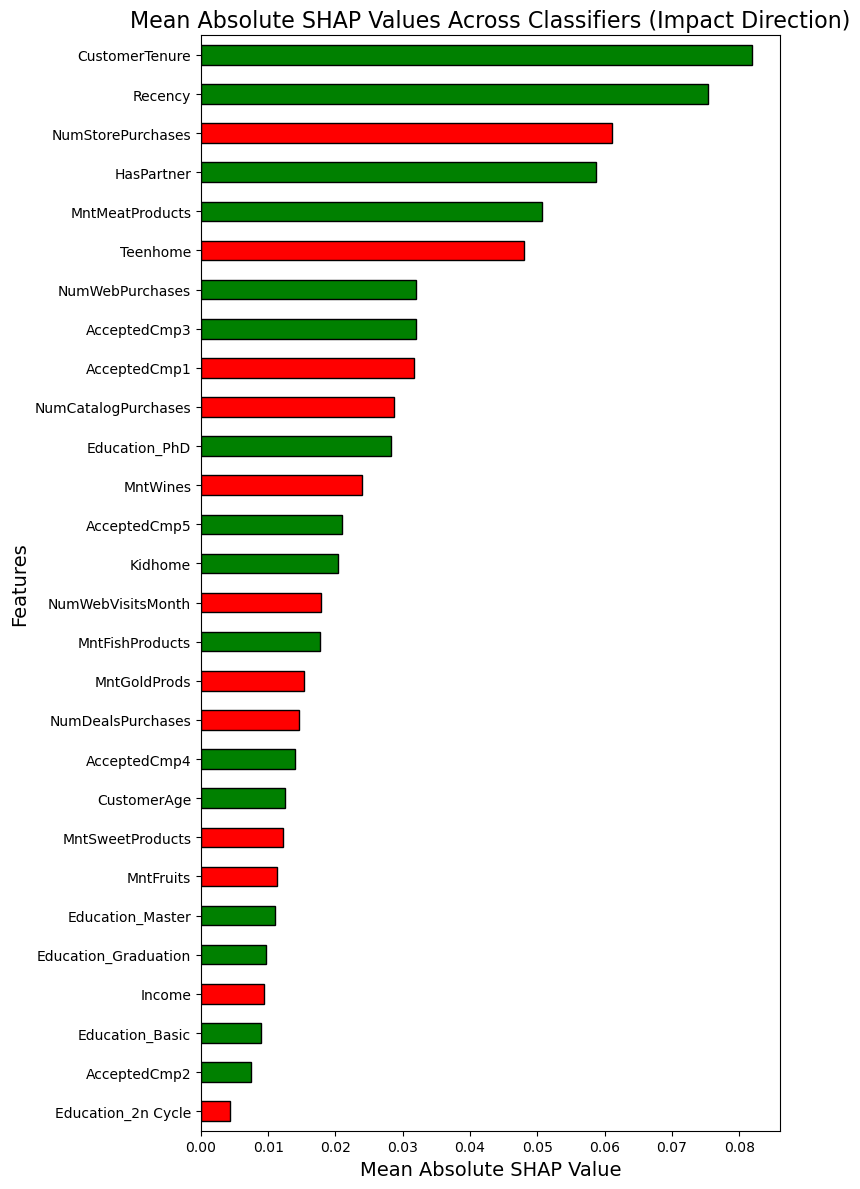

In [24]:
# Combine SHAP values into a single DataFrame
shap_values_combined = pd.DataFrame()

for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)  # Do not apply np.abs here
    
    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)  # Keep raw SHAP values
    shap_values_combined = pd.concat([shap_values_combined, shap_df], axis=0)

# Calculate the mean absolute SHAP value for each feature (for ranking)
mean_absolute_shap_values = shap_values_combined.abs().mean(axis=0)

# Calculate the mean SHAP value for each feature (for direction)
mean_shap_values = shap_values_combined.mean(axis=0)

# Sort features by mean absolute SHAP value
mean_absolute_shap_values = mean_absolute_shap_values.sort_values(ascending=False)

# Drop the 'Complain' variable if it exists
if 'Complain' in mean_absolute_shap_values.index:
    mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
if 'Complain' in mean_shap_values.index:
    mean_shap_values = mean_shap_values.drop('Complain')

# Align the mean SHAP values with the sorted absolute SHAP values for consistent ranking
mean_shap_values = mean_shap_values[mean_absolute_shap_values.index]

# Plot the mean absolute SHAP values with color indicating positive/negative impact
plt.figure(figsize=(8, 12))
colors = mean_shap_values.apply(lambda x: 'green' if x > 0 else 'red')  # Green for positive, red for negative
mean_absolute_shap_values.plot(kind='barh', color=colors, edgecolor='black')
plt.title('Mean Absolute SHAP Values Across Classifiers (Impact Direction)', fontsize=16)
plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
plt.tight_layout()
plt.show()

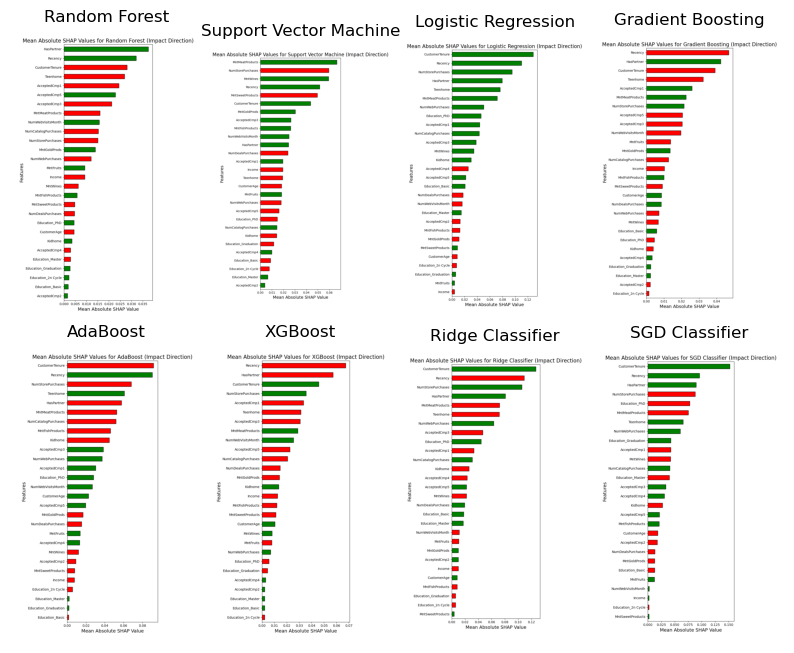

In [40]:
output_dir = "../reports/figures/shap_plots"
feature_names = data["feature_names"]

# Generate and save SHAP bar plots for each classifier
for clf_name, shap_values in shap_values_dict.items():
    # If the classifier is multi-class, sum SHAP values across classes
    if isinstance(shap_values, list):
        shap_values = np.sum(shap_values, axis=0)  # Do not apply np.abs here

    # Create a DataFrame for the current classifier's SHAP values
    shap_df = pd.DataFrame(shap_values, columns=feature_names)

    # Calculate mean absolute SHAP values (for ranking) and mean SHAP values (for direction)
    mean_absolute_shap_values = shap_df.abs().mean(axis=0).sort_values(ascending=False)
    mean_shap_values = shap_df.mean(axis=0)[mean_absolute_shap_values.index]  # Align with sorted absolute values

    # Drop the 'Complain' variable if it exists
    if 'Complain' in mean_absolute_shap_values.index:
        mean_absolute_shap_values = mean_absolute_shap_values.drop('Complain')
    if 'Complain' in mean_shap_values.index:
        mean_shap_values = mean_shap_values.drop('Complain')

    # Plot the mean absolute SHAP values with color indicating positive/negative impact
    plt.figure(figsize=(6, 12))
    colors = mean_shap_values.apply(lambda x: 'green' if x > 0 else 'red')  # Green for positive, red for negative
    mean_absolute_shap_values.plot(kind='barh', color=colors, edgecolor='black')
    plt.title(f"Mean Absolute SHAP Values for {clf_name} (Impact Direction)", fontsize=16)
    plt.xlabel('Mean Absolute SHAP Value', fontsize=14)
    plt.ylabel('Features', fontsize=14)
    plt.gca().invert_yaxis()  # Invert y-axis to show the most important features at the top
    plt.tight_layout()
    plt.savefig(f"{output_dir}/{clf_name}_shap_bar_col.png", bbox_inches='tight', pad_inches=0.4)
    plt.close()

# Display all SHAP bar plots in a single figure
num_classifiers = len(shap_values_dict)
num_cols = 4  # Number of columns in the grid
num_rows = (num_classifiers + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Adjust the figure size to make plots larger and reduce spacing
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(10, 4 * num_rows))  # Increase figure width and height

# Flatten axes array for easy iteration
axes = axes.flatten()

for ax, (clf_name, _) in zip(axes, shap_values_dict.items()):
    img = plt.imread(f"{output_dir}/{clf_name}_shap_bar_col.png")
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(clf_name, fontsize=12)  # Adjust font size for titles

# Hide any unused subplots
for i in range(num_classifiers, len(axes)):
    axes[i].axis('off')

# Adjust layout to reduce spacing between plots
plt.subplots_adjust(wspace=0.01, hspace=0.07)  # Reduce horizontal and vertical spacing
plt.show()
